# Import and preparation

In [ ]:
import numpy as np
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from collections import Counter
import random
warnings.filterwarnings('ignore')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Gdrive = GoogleDrive(gauth)


In [ ]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [ ]:
clinical = '19Q6-A4HTCVrMr65nGVeNCUqknUukqIun'
mep = '19SM9RvD5OOmyQ3MOHkjnfNx1JSHZikZZ'


In [ ]:
downloaded = Gdrive.CreateFile({'id':clinical}) 
downloaded.GetContentFile('clinical_data.csv')  
clinical = pd.read_csv('clinical_data.csv')

In [ ]:
Clinical_Copy = clinical.copy()

In [ ]:
downloaded = Gdrive.CreateFile({'id':mep}) 
downloaded.GetContentFile('mep_data.csv')  
mep = pd.read_csv('mep_data.csv')

In [ ]:
mep_Copy = mep.copy()

# Clinical Data dataset

In [ ]:
print("Clinical data: {} rows and {} columns".format(clinical.shape[0],clinical.shape[1]))

Clinical data: 7414 rows and 4 columns


In [ ]:
print("Motor Evoked data: {} rows and {} columns".format(mep.shape[0],mep.shape[1]))

Motor Evoked data: 13304 rows and 13 columns


In [ ]:
#removing unnecessary column(s)
clinical.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
print("Number of unique patients: {}".format(clinical['patient_uid'].nunique()))

Number of unique patients: 582


In [ ]:
print("Number of unique patients: {}".format(mep['patient_uid'].nunique()))

Number of unique patients: 520


In [ ]:
# convert to date to date format to calculate the differences btw dates
clinical['date'] = pd.to_datetime(clinical['date'],dayfirst=True, format='%d/%m/%Y')
#%Y Year, with century
#%m Month number, zero-padded
#%d Day of month, zero-padded

In [ ]:
clinical[clinical.isnull()].count()

date           0
edss           0
patient_uid    0
dtype: int64

In [ ]:
# Sorting by ascending by patient_uid and descending by date. We start with the most recent visit for each patient
clinical.sort_values(by=['patient_uid','date'], inplace=True, ascending=[True, False])
clinical.reset_index(drop=True, inplace=True)
clinical = clinical[['patient_uid', 'date', 'edss']]

In [ ]:
clinical.shape

(7414, 3)

In [ ]:
# Difference between 2 consecutive visits
clinical['diff'] = clinical.groupby('patient_uid')['date'].diff().abs().fillna(pd.Timedelta(days=0))
# cummulated sum of days per patient
clinical['diff_num'] = clinical['diff'].astype('timedelta64[D]')
clinical['cumsum'] = clinical.groupby(['patient_uid'])['diff_num'].cumsum()

In [ ]:
# create patient's group
byPatient = clinical.groupby('patient_uid') 

In [ ]:
# Resulting dataframe
dfObj = pd.DataFrame(columns=['patient_uid', 'dateT1', 'dateT0', 'edss1', 'edss0', 'index1', 'index0', 'diff' ])

# Two loops, the first goes between patients, second within patients.
# group contains all the individual patient visits

for g_uid, group in byPatient:

    group_2 = group
    period = 2 * 365
    patient_uid = g_uid
    
    for r_uid, row in group.iterrows():
        center = clinical.loc[r_uid,'cumsum'] 
        index1 = r_uid
        # for each visit row, we center with the current cummulative sum for each visit of the group, and substract the period,
        # the take abs and sort so we can select the closest to 0.
        index2 = (group_2['cumsum']-period-center).abs().sort_values().head(1).index[0]

        group_2 = group_2.drop([r_uid])
        indexes = [index1,index2]
        
        date1 = clinical.loc[[indexes[0]],['date']].values[0][0]
        edss1 =  clinical.loc[[indexes[0]],['edss']].values[0][0]
        date2 = clinical.loc[[indexes[1]],['date']].values[0][0]
        edss2 =  clinical.loc[[indexes[1]],['edss']].values[0][0]
        diff = (date1 - date2)
        dfObj = dfObj.append({'patient_uid': patient_uid, 'dateT1': date1, 'dateT0': date2, 
                              'edss1': edss1, 'edss0':edss2, 'index1': indexes[0], 'index0': indexes[1],
                             'diff': diff}, ignore_index=True)

        
   

In [ ]:
# limiting to +-6 months 
limitUp = math.ceil(365/2)
# limitUp

183

In [ ]:
# We need to keep visits that are the closest to 2 years time. We substract two years(365*2) and then keep the ones closes to 0
dfObj['diff_centered'] = (dfObj['diff'] - pd.to_timedelta(365*2, unit='d') ).abs()
# dfObj.head(6)

,patient_uid,dateT1,dateT0,edss1,edss0,index1,index0,diff,diff_centered
0,2,1988-12-01,1986-11-29,1.0,2.5,0,5,733 days,3 days
1,2,1988-05-29,1986-11-29,1.0,2.5,1,5,547 days,183 days
2,2,1987-11-25,1986-11-29,1.0,2.5,2,5,361 days,369 days
3,2,1987-06-03,1986-11-29,1.0,2.5,3,5,186 days,544 days
4,2,1987-01-01,1986-11-29,1.0,2.5,4,5,33 days,697 days
5,2,1986-11-29,1986-11-29,2.5,2.5,5,5,0 days,730 days


In [ ]:
dfObj['diff_centered'] = dfObj['diff_centered'].dt.days


In [ ]:
print('Number of observations: {}'.format(len(dfObj)))

Number of observations: 7414


In [ ]:
#Remove rows that are outside of the +-6 month difference boundaries
# this step below removes rows with a diff_centered larger than +-6 months
# dfObj = dfObj[dfObj['diff_centered'] <= pd.to_timedelta(limitUp, unit='d')]
dfObj = dfObj[dfObj['diff_centered'] <= limitUp]


In [ ]:
# and then from the duplicate T0 visits, we keep only the closest date to 2 years (or the min diff_centered)
idx = dfObj.groupby(['patient_uid','index0'])['diff_centered'].transform(min) == dfObj['diff_centered']
dfObj_ = dfObj[idx]


In [ ]:
print("Output: {} | rows Removed: {}".format(dfObj_.shape[0], dfObj.shape[0] - dfObj_.shape[0]))

Output: 3854 | rows Removed: 786


In [ ]:
dfObj_['diff_'] = dfObj_['diff'].dt.days
dfObj_['diff_'].max(), 2*365 + limitUp

(910, 913)

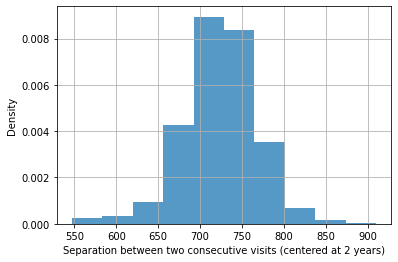

In [ ]:
# dfObj_['diffx'] = dfObj_['diff_centered'].dt.days

# plt.hist(dfObj_['diff'])
# dfObj_.diff.hist(bins=10)

# plt.hist(dfObj_['diff2'], 10, density=True,  alpha=0.75)

n, bins, patches =  plt.hist(dfObj_['diff_'], 10, density=True,  alpha=0.75)

plt.xlabel('Separation between two consecutive visits (centered at 2 years)')
plt.ylabel('Density')
# plt.title('Histogram of IQ')
# plt.xlim(40, 160)
# plt.ylim(0, 50)
plt.grid(True)
plt.show()

In [ ]:
dfObj_.drop(columns=['diff_centered','index1','index0'], inplace=True)

In [ ]:
# adding the incr/decr in the edss status
dfObj_['delta_edss'] = dfObj_['edss1'] - dfObj_['edss0']

Disability progression:

$$w_i=\begin{equation}
\left\{ 
  \begin{aligned}
    & 1 & & if & \Delta_{EDSS} \geq 1.5 & & \& & & EDSS_{T0} = 0\\
    & 1 & & if & \Delta_{EDSS} \geq 1   & & \& & & EDSS_{T0} \leq 5.5\\
    & 1 & & if & \Delta_{EDSS} \geq 0.5 & & \& & & EDSS_{T0} \gt 5.5\\
    & 0 & & otherwise & \\
  \end{aligned}
  \right.
\end{equation}
$$

In [ ]:
def conditions(s):
    if ((s['delta_edss'] >= 1.5) and (s['edss0'] == 0)) or \
       ((s['delta_edss'] >= 1) and (s['edss0'] <= 5.5)) or \
       ((s['delta_edss'] >= 0.5) and (s['edss0'] > 5.5)):
        return 1
    else:
        return 0

In [ ]:
dfObj_['w'] = dfObj_.apply(conditions, axis=1)

In [ ]:
print("proportion of positive outcomes: {}".format(dfObj_[(dfObj_["w"]==1)].size / dfObj_.size * 100))

proportion of positive outcomes: 11.883757135443695


In [ ]:
clinical_ = dfObj_.copy()

In [ ]:
# clinical_['disease_progression'] = clinical_['w'].astype('str')

In [ ]:
# clinical_.groupby('patient_uid')['disease_progression'].apply(''.join).reset_index()

In [1]:
# clinical_.head()

# Motor Evoked dataset

In [ ]:
mep.columns

Index(['anatomy', 'date_of_birth', 'marker_1_latency(ms)', 'measurement_uid',
       'patient_uid', 'test_uid', 'visit_uid', 'visit_date', 'sex', 'side',
       'machine', 'team', 'age'],
      dtype='object')

- anatomy: The muscle on which the measurement is performed. Possible values: 133 APB (50.71%), AH (49.29%)
- side: The side on which the measurement was performed, e.g., left or right arm. R (50.45%), L (49.55%)
- machine: Indicates which of the two machines the measurement was performed on. B (74.81%), A (25.19%)
- team: Indicates which team performed the measurements. Possible values: B (52.22%), A (47.78%)
- marker_1_latency(ms): the latency of marker 1, which were placed by nurses in the clinic.
- measurement_uid: unique identifier for a measurement. It is only unique in conjunction with the patient, visit, and test uid. Range: 0 - 16
- test_uid: A unique identifier for a test. It is only unique in conjunction with the patient, and visit uid. Range: 0 - 6
- visit_uid: A unique identifier for a visit. It is only unique in conjunction with the patient uid. Range: 0 - 25


In [ ]:
mep[mep['patient_uid']==11].head()

,anatomy,date_of_birth,marker_1_latency(ms),measurement_uid,patient_uid,test_uid,visit_uid,visit_date,sex,side,machine,team,age
88,APB,02/06/1927,22.35,1,11,0,0,30/08/2006,Male,R,A,B,79.244353
89,APB,02/06/1927,21.75,3,11,1,0,30/08/2006,Male,L,A,B,79.244353
90,AH,02/06/1927,49.00,3,11,2,0,30/08/2006,Male,R,A,B,79.244353
91,AH,02/06/1927,46.80,3,11,3,0,30/08/2006,Male,L,A,B,79.244353
92,APB,02/06/1927,24.30,4,11,0,1,31/01/2005,Male,R,A,A,77.667351


In [ ]:
# mep.groupby(['patient_uid']).agg({'visit_date': ['count']}).max()


In [ ]:
# mep.groupby(['patient_uid','visit_date']).nunique()

In [ ]:
#  mep.groupby('patient_uid')['visit_date'].nunique().max()

In [ ]:
# mep.groupby('patient_uid').agg({'visit_date': ['min']}).min()

In [ ]:
mep['visit_date'].min(), mep['visit_date'].max()

('01/01/1992', '31/12/2002')

In [ ]:
mep['anatomy_side'] = mep['anatomy'] + '-' + mep['side']

In [ ]:
mep['anatomy_side'].value_counts()

AH-R     3326
APB-R    3326
AH-L     3326
APB-L    3326
Name: anatomy_side, dtype: int64

In [ ]:
mep['date_of_birth'] = pd.to_datetime(mep["date_of_birth"], dayfirst=True, format='%d/%m/%Y')

In [ ]:
mep['visit_date'] = pd.to_datetime(mep["visit_date"], dayfirst=True, format='%d/%m/%Y')

In [ ]:
mep_ = mep[[
'patient_uid',
'visit_date',
# 'test_uid',
'anatomy_side',
# 'anatomy',
'marker_1_latency(ms)',
# 'measurement_uid',
'visit_uid',
'sex',
# 'side',
# 'machine',
# 'team',
'age',
'date_of_birth',
]]

In [ ]:
# This step transform the table from long to wide format, grouped by patient_uid. reset and rename_axis unstack the table 
# and removes the name of the index
mep_ = mep_.pivot_table(index=['patient_uid','visit_date','visit_uid','sex','age','date_of_birth'],
                   columns='anatomy_side',values='marker_1_latency(ms)').reset_index().rename_axis(None, axis=1)

Every row is a visit with the 4 measurements. Sorted ascending by patient and date. 
Next is to merge with the clinical data. 

In [ ]:
clinical['diff'] = clinical.groupby('patient_uid')['date'].diff().abs().fillna(pd.Timedelta(days=0))

clinical['diff_num'] = clinical['diff'].astype('timedelta64[D]')
clinical['cumsum'] = clinical.groupby(['patient_uid'])['diff_num'].cumsum()

In [ ]:
# mep_test = mep_.copy()

In [ ]:
mep_['diff_AH-L'] = mep_.groupby('patient_uid')['AH-L'].diff().fillna(0)
mep_['diff_AH-R'] = mep_.groupby('patient_uid')['AH-R'].diff().fillna(0)
mep_['diff_APB-L'] = mep_.groupby('patient_uid')['APB-L'].diff().fillna(0)
mep_['diff_APB-R'] = mep_.groupby('patient_uid')['APB-R'].diff().fillna(0)
mep_.head()

,patient_uid,visit_date,visit_uid,sex,age,date_of_birth,AH-L,AH-R,APB-L,APB-R,diff_AH-L,diff_AH-R,diff_APB-L,diff_APB-R
0,2,1987-06-04,2,Female,25.002053,1962-06-03,33.958333,34.427083,16.770833,17.187500,0.000000,0.000000,0.000000,0.000000
1,2,1987-11-26,3,Female,25.481177,1962-06-03,35.312500,33.229167,17.604167,18.489583,1.354167,-1.197916,0.833334,1.302083
2,2,1988-05-30,4,Female,25.990418,1962-06-03,35.312500,34.791667,17.500000,17.916667,0.000000,1.562500,-0.104167,-0.572916
3,2,1988-12-02,0,Female,26.499658,1962-06-03,33.958333,33.854167,17.812500,17.187500,-1.354167,-0.937500,0.312500,-0.729167
4,7,2004-07-06,1,Female,68.577687,1935-12-08,44.700000,42.450000,24.250000,21.450000,0.000000,0.000000,0.000000,0.000000


In [ ]:
clinical_.sort_values(by=['patient_uid','dateT1'], inplace=True, ascending=[True, True])

In [ ]:
clinical_.reset_index(inplace=True, drop=True)

In [ ]:
#Split clinical outcomes dataset with mathching (and not) in mep 
clinical_Out = clinical_[~clinical_['patient_uid'].isin(mep_['patient_uid'])].dropna()

In [ ]:
clinical_In = clinical_[clinical_['patient_uid'].isin(mep_['patient_uid'])].dropna()

In [ ]:
print("Number of obs: {}, number of unique patients: {}".format(len(clinical_In), clinical_In['patient_uid'].nunique()))

Number of obs: 3500, number of unique patients: 440


In [ ]:
print("Number of obs: {}, number unique patients: {}".format(len(clinical_Out), clinical_Out['patient_uid'].nunique()))

Number of obs: 354, number unique patients: 51


In [ ]:
mep_bk = mep_.copy()
clinical_In_bk = clinical_In.copy()

# mep_ = mep_bk.copy()
# clinical_In = clinical_In_bk.copy()

In [ ]:
# Only for testing! (change n to include more patients)
# n = 1
# test = random.choices(clinical_In['patient_uid'].unique().tolist(),k=n)

In [ ]:
# Only for testing!
# clinical_In = clinical_In_bk[clinical_In_bk['patient_uid'].isin(test)]
# mep_ = mep_bk[mep_bk['patient_uid'].isin(test)]

# Merge

In [ ]:
dfObj_ = pd.DataFrame(columns= (clinical_In.columns.tolist() + mep_.columns[1:].tolist() + ['xdiff'] + ['flag']) )

for r_uid, row in clinical_In.iterrows():
    # 
    dateT0 = row['dateT0']
    patientID = row['patient_uid']
    
    xx_dif = (mep_[mep_['patient_uid']==patientID]['visit_date'] -  dateT0)
    xx_abs = xx_dif.abs().sort_values().head(1)
    xx_abs_idx = xx_abs.index[0]

    # Absolute closest date to each clinical visit.
    xdiff = (mep_.loc[[xx_abs_idx],'visit_date']  -  dateT0).values.astype('timedelta64[D]')[0]
    
    # flag variable to find out which case we're dealing with.
    flag = 0

    # mep visit that are too far away from clinical visits are replaced by a previous 
    # visit if that is available, regarless of the (time) distance, 
    # if none is available, we leave the distance visit.

    if abs(xdiff) > np.timedelta64(365,'D'):
      flag = 1
      if np.any(xx_dif < np.timedelta64(0,'D')):
        # cases where the closest is furter away than 1 year and they have negative date values
        flag = 2
        # we select the closes negative value
        xx_neg = xx_dif[xx_dif < np.timedelta64(0,'D')].sort_values(ascending=False).head(1)
        # print(xx_neg,xdiff)
        xx_abs_idx = xx_neg.index[0]
        xdiff = xx_neg.values.astype('timedelta64[D]')[0]

      else:
        # continue
        flag = 3

    xdiff = abs(xdiff)
    dicts_c = {}
    for column in  clinical_In.columns.tolist():
        dicts_c[column] = row[column]
   
    dicts_m = {}
    for column in  mep_.columns[1:].tolist():
        dicts_m[column] = mep_.loc[xx_abs_idx,column]

    z = {**dicts_c, **dicts_m, 'xdiff': xdiff, 'flag': flag}
    dfObj_ = dfObj_.append(z, ignore_index=True)

dateT0 should match the closest visit_date from the Motor Evoked Dataset. \\
The output dataset (dfObj_) should have as many rows as the clinical dataset. 

In [ ]:
dfObj_[dfObj_['w']==1]

,patient_uid,dateT1,dateT0,edss1,edss0,diff,diff_,delta_edss,w,visit_date,visit_uid,sex,age,date_of_birth,AH-L,AH-R,APB-L,APB-R,diff_AH-L,diff_AH-R,diff_APB-L,diff_APB-R,xdiff,flag
22,10,1993-01-30,1991-03-20,3.5,2.5,682 days,682,1.0,1,1991-03-21,0,Female,38.428474,1952-10-15,46.500000,43.500000,23.350000,21.650000,6.239583,-1.343750,1.683333,1.441667,1 days,0
23,10,1993-09-18,1991-09-04,3.5,2.5,745 days,745,1.0,1,1991-09-05,8,Female,38.888433,1952-10-15,41.197917,42.604167,24.166667,19.739583,-5.302083,-0.895833,0.816667,-1.910417,1 days,0
28,11,2004-07-10,2002-05-22,4.5,3.5,780 days,780,1.0,1,2002-05-22,2,Male,74.970568,1927-06-02,47.135417,49.375000,22.187500,24.270833,0.000000,0.000000,0.000000,0.000000,0 days,0
29,11,2004-09-04,2002-09-04,4.5,3.5,731 days,731,1.0,1,2002-09-05,9,Male,75.260780,1927-06-02,46.822917,48.281250,22.031250,23.385417,-0.312500,-1.093750,-0.156250,-0.885416,1 days,0
30,11,2005-01-26,2003-01-04,5.5,3.5,753 days,753,2.0,1,2003-01-05,8,Male,75.594798,1927-06-02,47.500000,49.583333,22.135417,21.562500,0.677083,1.302083,0.104167,-1.822917,1 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,950,2011-08-30,2009-06-02,6.5,6.0,819 days,819,0.5,1,2010-03-09,0,Male,64.172485,1946-01-05,42.450000,60.100000,28.750000,26.500000,-1.612500,8.172917,-1.666667,-1.468750,280 days,0
3472,953,2010-09-06,2008-08-31,4.5,3.0,736 days,736,1.5,1,2008-08-31,0,Female,63.923340,1944-09-28,33.950000,35.100000,18.350000,18.700000,0.000000,0.000000,0.000000,0.000000,0 days,0
3488,962,1992-03-22,1990-07-18,1.0,0.0,613 days,613,1.0,1,1991-03-25,4,Female,33.889117,1957-05-04,35.468750,34.687500,18.489583,17.604167,-0.833333,-2.812500,-2.031250,-2.395833,250 days,0
3494,962,1995-09-10,1993-09-19,2.0,1.0,721 days,721,1.0,1,1993-09-19,1,Female,36.377823,1957-05-04,35.781250,33.437500,17.500000,17.239583,0.885417,1.822917,-0.104167,1.822916,0 days,0


In [ ]:
# display_side_by_side([clinical_In[clinical_In['patient_uid'].isin(test)], mep_[mep_['patient_uid'].isin(test)]], ['Clinical data', 'Motor Evoked'])

In [ ]:
print("proportion of positive outcomes: {}".format(dfObj_[(dfObj_["w"]==1)].size / dfObj_.size * 100))

proportion of positive outcomes: 11.0


In [ ]:
Counter(dfObj_["w"])

Counter({0: 3115, 1: 385})

In [ ]:
len(dfObj_[dfObj_['flag']==2]) + len(dfObj_[dfObj_['flag']==3]) 

717

In [ ]:
duplicateRowsDF = dfObj_[dfObj_.duplicated(['patient_uid','visit_date'])]['patient_uid'].tolist()
duplicate_list = set(duplicateRowsDF)

# duplicateRowsDF = dfObj_[dfObj_.duplicated(['patient_uid','visit_date'])]
dfObj_[dfObj_['patient_uid'].isin(duplicate_list)].head()

,patient_uid,dateT1,dateT0,edss1,edss0,diff,diff_,delta_edss,w,visit_date,visit_uid,sex,age,date_of_birth,AH-L,AH-R,APB-L,APB-R,diff_AH-L,diff_AH-R,diff_APB-L,diff_APB-R,xdiff,flag
1,7,2005-05-04,2003-05-28,3.5,4.0,707 days,707,-0.5,0,2004-07-06,1,Female,68.577687,1935-12-08,44.700000,42.450000,24.25000,21.450000,0.000000,0.000000,0.00000,0.000000,405 days,3
2,7,2005-11-29,2004-05-28,3.5,4.0,550 days,550,-0.5,0,2004-07-06,1,Female,68.577687,1935-12-08,44.700000,42.450000,24.25000,21.450000,0.000000,0.000000,0.00000,0.000000,39 days,0
3,7,2006-07-29,2004-08-27,3.5,4.0,701 days,701,-0.5,0,2004-07-06,1,Female,68.577687,1935-12-08,44.700000,42.450000,24.25000,21.450000,0.000000,0.000000,0.00000,0.000000,52 days,0
4,7,2007-01-26,2005-02-25,3.5,3.5,700 days,700,0.0,0,2005-08-05,4,Female,69.659138,1935-12-08,45.260417,42.239583,23.28125,19.895833,0.560417,-0.210417,-0.96875,-1.554167,161 days,0
5,7,2007-07-28,2005-08-05,4.0,3.5,722 days,722,0.5,0,2005-08-05,4,Female,69.659138,1935-12-08,45.260417,42.239583,23.28125,19.895833,0.560417,-0.210417,-0.96875,-1.554167,0 days,0


In [ ]:
# Remove duplicates visit_date 
dfObj_1 = dfObj_.loc[dfObj_.groupby(['patient_uid','visit_date'])['xdiff'].idxmin()]

In [ ]:
# print("proportion of positive outcomes: {}".format(dfObj_1[(dfObj_1["w"]==1)].size / dfObj_1.size * 100))

In [ ]:
# Counter(dfObj_1["w"])

In [ ]:
print("{} rows were removed, there are now {} left".format(len(dfObj_)- len(dfObj_1),len(dfObj_1)))

1444 rows were removed, there are now 2056 left


In [ ]:
print("|| No disease progression(0): {} || Disease progression(1) :{} ||".format(Counter(dfObj_1["w"])[0] , Counter(dfObj_1["w"])[1]))

|| No disease progression(0): 1826 || Disease progression(1) :230 ||


In [ ]:
print("From {} to {} cases (duplicated cases), proportion is {} and was {}".format(Counter(dfObj_["w"])[1],Counter(dfObj_1["w"])[1], dfObj_[(dfObj_["w"]==1)].size / dfObj_.size * 100, dfObj_1[(dfObj_1["w"]==1)].size / dfObj_1.size * 100))

From 417 to 254 cases (duplicated cases), proportion is 11.409028727770178 and was 11.737523105360443


In [ ]:
# change sign of the negative dates (flag=2)
dfObj_1['xdiff'] = np.where((dfObj_1.flag == 2),dfObj_1.xdiff * -1,dfObj_1.xdiff)

In [ ]:
dfObj_1[dfObj_1['flag']==3]['patient_uid'].nunique()

15

In [ ]:
final = dfObj_2.copy()

In [ ]:
final.sort_values(by=['patient_uid','visit_date'], inplace=True, ascending=[True, False])

In [ ]:
final.reset_index(inplace=True, drop=True)

In [ ]:
final.shape

(2139, 24)

In [ ]:
print("|| No disease progression(0): {} || Disease progression(1) :{} ||".format(Counter(final["w"])[0] , Counter(final["w"])[1]))

|| No disease progression(0): 1889 || Disease progression(1) :250 ||


In [ ]:
# format timedelta days to int
final['xdiff'] = final['xdiff'].dt.days
final['diff'] = final['diff'].dt.days

In [ ]:
final.tail()

,patient_uid,dateT1,dateT0,edss1,edss0,diff,diff2,delta_edss,w,visit_date,visit_uid,sex,age,date_of_birth,AH-L,AH-R,APB-L,APB-R,diff_AH-L,diff_AH-R,diff_APB-L,diff_APB-R,xdiff,flag
2134,962,1995-09-10,1993-09-19,2.0,1.0,721,9,1.0,1,1993-09-19,1,Female,36.377823,1957-05-04,35.781250,33.437500,17.500000,17.239583,0.885417,1.822917,-0.104167,1.822916,0,0
2135,962,1995-03-12,1993-03-21,1.0,1.0,721,9,0.0,0,1993-03-22,13,Female,35.882272,1957-05-04,34.895833,31.614583,17.604167,15.416667,0.416666,-2.864584,-0.312500,-2.760416,1,0
2136,962,1994-03-28,1992-03-22,1.0,1.0,736,6,0.0,0,1992-03-23,2,Female,34.885695,1957-05-04,36.197917,35.416667,18.489583,16.614583,2.083334,0.625000,1.666666,-0.312500,1,0
2137,962,1993-10-12,1991-10-03,1.0,1.0,740,10,0.0,0,1991-10-03,8,Female,34.414784,1957-05-04,34.114583,34.791667,16.822917,16.927083,-1.093750,-0.885416,-0.989583,-0.260417,0,0
2138,962,1993-03-21,1991-03-24,1.0,1.0,728,2,0.0,0,1991-03-25,4,Female,33.889117,1957-05-04,35.468750,34.687500,18.489583,17.604167,-0.833333,-2.812500,-2.031250,-2.395833,1,0


In [ ]:
final_X = final.copy()
final_X['edss_class'] = np.where(final_X['edss0'] >= 6, 'edss>=6', 'edss<6' ) 

# final_X.head(50)

In [ ]:
final_minus = final_X[final_X['edss0'] < 6]
final_plus = final_X[final_X['edss0'] >= 6]
# final_minus.shape,final_plus.shape,final_X.shape
# ((1877, 25), (262, 25), (2139, 25))
final_minus['AH-R'].mean(),final_plus['AH-R'].mean()

(40.95370493340436, 48.890195606870265)

In [ ]:
final_minus['AH-L'].mean(),final_plus['AH-L'].mean()

(41.19289202503994, 47.73480440839694)

In [ ]:
final_minus['APB-R'].mean(),final_plus['APB-R'].mean()

(20.585347861481097, 24.10042940839695)

In [ ]:
final_minus['APB-L'].mean(),final_plus['APB-L'].mean()

(20.415313676611596, 23.98893128625955)

In [ ]:
# import seaborn as sns
!pip install joypy
import joypy 

In [ ]:
# df[(df['Salary_in_1000']>=100) & (df['Age']<60) & df['FT_Team'].str.startswith('S')][['Name','Age','Salary_in_1000']]

final_R = final_X[(final_X['AH-R']>=19) & (final_X['AH-R']<80) & (final_X['APB-R']>19)  & (final_X['APB-R']<80) ] 
# final_AHR = final_X[(final_X['AH-R']>20)  & (final_X['AH-R']<81)] 
final_L = final_X[(final_X['AH-L']>19) & (final_X['AH-L']<80) & (final_X['APB-L']>19) & (final_X['APB-L']<80)] 
# final_APBR = final_X[(final_X['APB-R']>20) & (final_X['APB-R']<81)] 

# x_range = list(range(15,80))
# range(15,80,5)
final_R['AH-R'].min(),final_R['AH-R'].max()

(19.7, 77.65625)

<Figure size 1280x800 with 0 Axes>

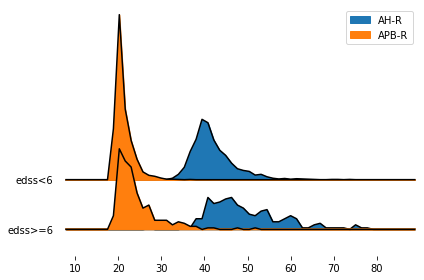

In [ ]:
%matplotlib inline
x_range = list(range(20,80,5))
plt.figure(figsize=(16,10), dpi= 80)
# fig, axes = joypy.joyplot(mep_, column=['AH-L', 'APB-L','AH-R','APB-R'], by="sex", ylim='own', figsize=(14,10))
# fig, axes = joypy.joyplot(final_X, column=['AH-L', 'APB-L'],by="edss_class", overlap=3,grid=False, legend=True, kind="counts")
fig, axes = joypy.joyplot(final_R, column=['AH-R', 'APB-R'],by="edss_class", overlap=3,grid=False, legend=True, kind="normalized_counts",bins=60)
# fig, axes = joypy.joyplot(final_L, column=['AH-L', 'APB-L'],by="edss_class", overlap=3,grid=False, legend=True, kind="normalized_counts",bins=60)
# axes[-1].set_xticks(x_range);
# axes[-1].set_xticklabels(x_range)

# fig, axes = joypy.joyplot(final_X, column=['AH-R', 'APB-R'],by="edss_class", overlap=3,grid=False, legend=True, kind="normalized_counts",bins=60)
# fig, axes = joypy.joyplot(mep_, column=['AH-L', 'AH-R','APB-L','APB-R'],hist="True", bins=50, overlap=0,grid=False, legend=False)
# fig, axes = joypy.joyplot(mep_, column=['AH-L', 'APB-L','AH-R','APB-R'], by='sex', overlap=1)
# Decoration
# plt.title('Anatomy distribution of latencies for patients with EDSS>5', fontsize=22)
plt.show()

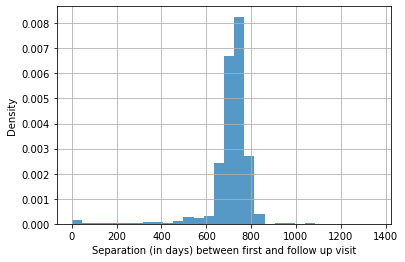

In [ ]:
# dfObj_['diff2'] = dfObj_['diff_centered'].dt.days

# plt.hist(dfObj_['diff'])
# dfObj_.diff.hist(bins=10)

# plt.hist(dfObj_['diff2'], 10, density=True,  alpha=0.75)

# n, bins, patches =  plt.hist(final['xdiff'], 10, density=True,  alpha=0.75)
n, bins, patches =  plt.hist(final['diff'], 30, density=True,  alpha=0.75)
# plt.xlabel('Separation (in days) between clinical and MEP visits')
plt.xlabel('Separation (in days) between first and follow up visit')
plt.ylabel('Density')

plt.grid(True)
plt.show()

In [ ]:
final_ = final[[
 'patient_uid',
 'sex',
 'age',
 'date_of_birth',
 'visit_uid',
 'visit_date',
 'dateT0',
 'edss0',
 'dateT1',
 'edss1',
 'delta_edss',
 'AH-L',
 'diff_AH-L',
 'AH-R',
 'diff_AH-R',
 'APB-L',
 'diff_APB-L',
 'APB-R',
 'diff_APB-R',
 'w'
 ]]

In [ ]:
final_.tail()

,patient_uid,sex,age,date_of_birth,visit_uid,visit_date,dateT0,edss0,dateT1,edss1,delta_edss,AH-L,diff_AH-L,AH-R,diff_AH-R,APB-L,diff_APB-L,APB-R,diff_APB-R,w
2134,962,Female,36.377823,1957-05-04,1,1993-09-19,1993-09-19,1.0,1995-09-10,2.0,1.0,35.781250,0.885417,33.437500,1.822917,17.500000,-0.104167,17.239583,1.822916,1
2135,962,Female,35.882272,1957-05-04,13,1993-03-22,1993-03-21,1.0,1995-03-12,1.0,0.0,34.895833,0.416666,31.614583,-2.864584,17.604167,-0.312500,15.416667,-2.760416,0
2136,962,Female,34.885695,1957-05-04,2,1992-03-23,1992-03-22,1.0,1994-03-28,1.0,0.0,36.197917,2.083334,35.416667,0.625000,18.489583,1.666666,16.614583,-0.312500,0
2137,962,Female,34.414784,1957-05-04,8,1991-10-03,1991-10-03,1.0,1993-10-12,1.0,0.0,34.114583,-1.093750,34.791667,-0.885416,16.822917,-0.989583,16.927083,-0.260417,0
2138,962,Female,33.889117,1957-05-04,4,1991-03-25,1991-03-24,1.0,1993-03-21,1.0,0.0,35.468750,-0.833333,34.687500,-2.812500,18.489583,-2.031250,17.604167,-2.395833,0


In [ ]:
final_.dtypes

patient_uid              object
sex                      object
age                     float64
date_of_birth    datetime64[ns]
visit_uid                object
visit_date       datetime64[ns]
dateT0           datetime64[ns]
edss0                   float64
dateT1           datetime64[ns]
edss1                   float64
delta_edss              float64
AH-L                    float64
diff_AH-L               float64
AH-R                    float64
diff_AH-R               float64
APB-L                   float64
diff_APB-L              float64
APB-R                   float64
diff_APB-R              float64
w                        object
dtype: object

In [ ]:
final_.isnull().sum()


patient_uid      0
sex              0
age              0
date_of_birth    0
visit_uid        0
visit_date       0
dateT0           0
edss0            0
dateT1           0
edss1            0
delta_edss       0
AH-L             0
diff_AH-L        0
AH-R             0
diff_AH-R        0
APB-L            0
diff_APB-L       0
APB-R            0
diff_APB-R       0
w                0
dtype: int64

In [ ]:
drive.mount('/drive')


Mounted at /drive


In [ ]:
# final_.to_csv('/drive/My Drive/Javier/Data/final.csv')

In [ ]:
final_.to_csv('/drive/My Drive/Javier/Data/final_wider.csv')

# Histograms

In [ ]:
final_['AH-L'].describe()

count    2139.000000
mean       41.994192
std         6.089811
min         9.843750
25%        38.229167
50%        40.500000
75%        44.464584
max        78.593750
Name: AH-L, dtype: float64

In [ ]:
final_['AH-R'].describe()

count    2139.000000
mean       41.925823
std         6.476733
min         1.875000
25%        38.072917
50%        40.572917
75%        44.322917
max        87.600000
Name: AH-R, dtype: float64

In [ ]:
final_['APB-L'].describe()

count    2139.000000
mean       20.853036
std         3.149264
min        14.427083
25%        19.132292
50%        20.156250
75%        21.785417
max        61.550000
Name: APB-L, dtype: float64

In [ ]:
final_['APB-R'].describe()

count    2139.000000
mean       21.015900
std         3.166079
min        14.479167
25%        19.375000
50%        20.260417
75%        21.900000
max        69.750000
Name: APB-R, dtype: float64

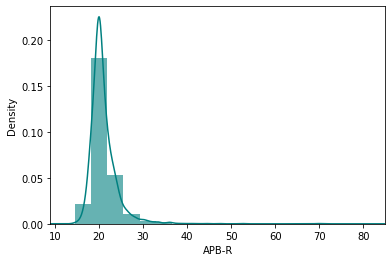

In [ ]:
ax = final_["APB-R"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
final_["APB-R"].plot(kind='density', color='teal')
ax.set(xlabel='APB-R')
ax.set(xlabel='APB-R')
plt.xlim(9,85)
plt.show()

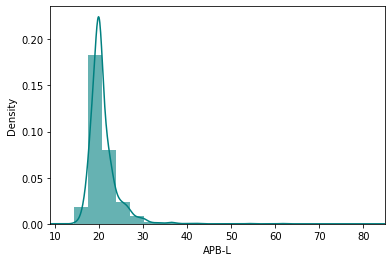

In [ ]:
ax = final_["APB-L"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
final_["APB-L"].plot(kind='density', color='teal')
ax.set(xlabel='APB-L')
ax.set(xlabel='APB-L')
plt.xlim(9,85)
plt.show()

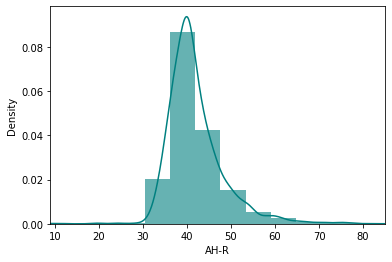

In [ ]:
ax = final_["AH-R"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
final_["AH-R"].plot(kind='density', color='teal')
ax.set(xlabel='AH-R')
plt.xlim(9,85)
plt.show()

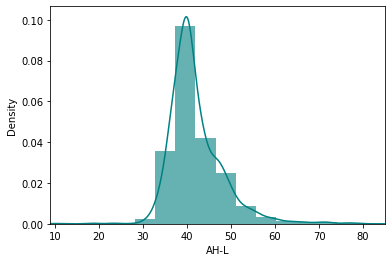

In [ ]:
ax = final_["AH-L"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
final_["AH-L"].plot(kind='density', color='teal')
ax.set(xlabel='AH-L')
plt.xlim(9,85)
plt.show()